In [1]:
#basic
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

#torchvision
import torchvision
from torchvision import transforms, datasets

from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import shutil
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)


PyTorch version in use: 2.4.1+cu118 
cuda avail:  True


C:\Users\ricig\AppData\Local\Temp\ipykernel_20224\1903050231.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Device: cuda


In [ ]:
file_path = "./Dataset_Truss_SysId_Gap9/sysid/"
file_pattern = "anomaly_{}.csv"

# Initialize an empty list to store DataFrames
df_list = []

# Loop through the files and read them into DataFrames
for i in range(1, 10):
    file_name = file_path + file_pattern.format(i)
    df = pd.read_csv(file_name, header=None, skiprows=1)
    df_list.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df)


In [ ]:
# Convert DataFrame to a NumPy array
data_array = combined_df.to_numpy()

# Flatten the array
flattened_array = data_array.flatten()

num_elements = len(flattened_array)
num_1x512_arrays = num_elements // 512

# Only include full 1x512 arrays
anomaly_reshaped_array = flattened_array[:num_1x512_arrays * 512].reshape(-1, 512)
# Print the shape to verify
print(anomaly_reshaped_array.shape)
print(anomaly_reshaped_array)


In [2]:
file_path = "./Dataset_Truss_SysId_Gap9/sysid/"
file_pattern = "anomaly_{}.csv"

# Initialize an empty dictionary to store DataFrames
df_dict = {}

# Initialize an empty dictionary to store reshaped arrays
reshaped_arrays_dict = {}

# Loop through the files and read them into DataFrames
for i in range(1, 10):
    file_name = file_path + file_pattern.format(i)
    df = pd.read_csv(file_name, header=None, skiprows=1)
    df_dict[i] = df  # Save each DataFrame in the dictionary with the file number as the key
    
    # Convert DataFrame to a NumPy array
    data_array = df.to_numpy()
    
    # Flatten the array
    flattened_array = data_array.flatten()
    
    num_elements = len(flattened_array)
    num_1x512_arrays = num_elements // 512
    
    # Only include full 1x512 arrays
    reshaped_array = flattened_array[:num_1x512_arrays * 512].reshape(-1, 512)
    
    # Store the reshaped array in the dictionary
    reshaped_arrays_dict[i] = reshaped_array

# Example: Display the shape of the reshaped arrays to verify
for key, array in reshaped_arrays_dict.items():
    print(f"Reshaped Array {key} shape: {array.shape}")

# Example: Access and display a specific reshaped array
example_reshaped_array = reshaped_arrays_dict[1]
print(f"\nExample Reshaped Array 1:\n{example_reshaped_array}")


Reshaped Array 1 shape: (7347, 512)
Reshaped Array 2 shape: (7960, 512)
Reshaped Array 3 shape: (7960, 512)
Reshaped Array 4 shape: (7347, 512)
Reshaped Array 5 shape: (7347, 512)
Reshaped Array 6 shape: (7960, 512)
Reshaped Array 7 shape: (7960, 512)
Reshaped Array 8 shape: (7960, 512)
Reshaped Array 9 shape: (8578, 512)

Example Reshaped Array 1:
[[ 0.33508414  0.33690926  0.33443159 ... -0.73923749 -0.14759994
   0.3267535 ]
 [ 0.44003785  0.25778097  0.18253256 ... -1.33947003 -1.2317096
  -0.93552095]
 [-0.58727443 -0.42815647 -0.59677106 ...  1.2138288   1.1254679
   0.94096661]
 ...
 [-0.32667741 -0.28957447 -0.30746761 ...  0.15907706 -0.23413724
  -0.63268739]
 [-0.91950518 -1.08142853 -1.12778628 ...  0.80925584  0.88106281
   0.97820562]
 [ 0.99122626  0.8565414   0.65228313 ... -0.54779613 -0.43893901
  -0.25279745]]


In [3]:
file_path = "./Dataset_Truss_SysId_Gap9/sysid/"

# Initialize an empty list to store DataFrames
df_list = []

df = pd.read_csv(file_path+"x_test.csv", header=None, skiprows=1)
df_list.append(df)
df = pd.read_csv(file_path+"x_train.csv", header=None, skiprows=1)
df_list.append(df)
df = pd.read_csv(file_path+"x_validation.csv", header=None, skiprows=1)
df_list.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df)


           0         1         2         3         4         5         6     \
0      5.392956  5.428917  5.376329  5.340400  5.233158  5.110609  5.026137   
1      1.488341  0.021150 -1.420335 -2.491002 -2.847655 -2.682484 -2.473964   
2     -2.609304 -2.636410 -2.082529 -1.049911  0.088752  1.126209  2.073311   
3      2.331606  2.118372  1.985599  1.806006  1.343558  0.744766  0.291994   
4     -3.814505 -3.476510 -3.099672 -2.688232 -2.090873 -1.348042 -0.635731   
...         ...       ...       ...       ...       ...       ...       ...   
17135 -0.037920 -0.054897 -0.034926 -0.056259 -0.132441 -0.128852 -0.015717   
17136  0.251398  0.184543  0.145010  0.138204  0.088129 -0.054267 -0.178553   
17137  0.251097  0.122191 -0.065286 -0.223846 -0.233973 -0.124868 -0.032228   
17138 -0.351340 -0.309985 -0.177594 -0.065977 -0.077860 -0.110838 -0.042168   
17139 -0.037949  0.018861  0.034028  0.076020  0.163944  0.182898  0.079670   

           7         8         9     ...      1990 

In [4]:
# Convert DataFrame to a NumPy array
data_array = combined_df.to_numpy()

# Flatten the array
flattened_array = data_array.flatten()

num_elements = len(flattened_array)
num_1x512_arrays = num_elements // 512

# Only include full 1x512 arrays
ok_reshaped_array = flattened_array[:num_1x512_arrays * 512].reshape(-1, 512)
# Print the shape to verify
print(ok_reshaped_array.shape)
print(ok_reshaped_array)


(66953, 512)
[[ 5.39295578  5.42891741  5.37632895 ... -2.02515125 -2.00981998
  -2.00674844]
 [-1.77831304 -1.25937855 -0.54760677 ... -3.00532842 -3.09841657
  -2.94735694]
 [-2.62580562 -2.13840008 -1.46491671 ... -2.86929297 -2.85892129
  -2.60238051]
 ...
 [ 0.34892261  0.56465948  0.39679974 ... -0.09781012 -0.10131732
  -0.0502051 ]
 [-0.07992867 -0.1185106  -0.02422599 ...  0.13251454 -0.09893569
  -0.28008685]
 [-0.35711423 -0.34346053 -0.2358688  ...  0.01034783  0.08349875
   0.0464907 ]]


In [5]:
def save_arrays_labeled(reshaped_array, output_directory, label):
    # Loop through each row in the reshaped array
    for i in range(reshaped_array.shape[0]):
        # Extract the current 1x512 array
        single_array = reshaped_array[i]
        
        # Define the file name for the output
        file_name = f'{output_directory}/array_{i}_{label}.npy'
        
        # Save the array as a .npy file
        np.save(file_name, single_array)


In [8]:
output_directory = './output_arrays_labeledanomalies'

if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

os.makedirs(output_directory)

# Call the function to save the arrays
for i in range(1, 10):
    save_arrays_labeled(reshaped_arrays_dict[i], output_directory, i)
save_arrays_labeled(ok_reshaped_array, output_directory, 0)

In [9]:
reshaped_arrays_dict = []
ok_reshaped_array = []

# If provided dataset, start from here

In [2]:
def load_dataset_and_labels(directory):
    # Initialize lists to hold the data and labels
    data = []
    labels = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):
            # Load the .npy file
            array = np.load(os.path.join(directory, filename))
            
            # Extract the label from the filename
            label = int(filename.split('_')[2].split('.')[0])
            
            # Append the array and label to the respective lists
            data.append(array)
            labels.append(label)
    
    # Convert lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

output_directory = './output_arrays'
# Call the function to load the dataset and labels
data, labels = load_dataset_and_labels(output_directory)

# Print shapes to verify
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (137378, 512)
Labels shape: (137378,)


In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

custom_dataset = CustomDataset(data_tensor, labels_tensor)


In [4]:
data = []
labels = []

In [5]:
batch_size = 128

def get_data_loaders(dataset, train_batch_size=batch_size, val_batch_size=batch_size, test_batch_size=batch_size, train_ratio=0.7, val_ratio=0.15):
    # Ensure the ratios sum to 1
    test_ratio = 1 - train_ratio - val_ratio
    if test_ratio <= 0:
        raise ValueError("The sum of train_ratio and val_ratio must be less than 1.")
    
    # Determine sizes for training, validation, and test sets
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create DataLoaders for the splits
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    print(f"Dataset split sizes - Train: {train_size}, Validation: {val_size}, Test: {test_size}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Example usage
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

# Check one batch from the train loader
for batch_idx, (samples, labels) in enumerate(train_loader):
    print(f"Train Batch {batch_idx}:")
    print(f"Samples: {samples.shape}")
    print(f"Labels: {labels.shape}")
    break  # Just to see the first batch


Dataset split sizes - Train: 96164, Validation: 20606, Test: 20608
Number of training batches: 752
Number of validation batches: 161
Number of test batches: 161
Train Batch 0:
Samples: torch.Size([128, 512])
Labels: torch.Size([128])


In [6]:
class CNN(nn.Module):
    def __init__(self, n_classes=2):
        super(CNN, self).__init__()
        
        # First convolution layer: input 1x512x1 -> output 50x512x1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=(3, 1), stride=1, padding=(1, 0))
        
        # Second convolution layer: input 50x512x1 -> output 30x512x1
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=30, kernel_size=(3, 1), stride=1, padding=(1, 0))
        
        # Max Pooling: input 30x512x1 -> output 30x256x1
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1))
        
        # Third convolution layer: input 30x256x1 -> output 30x256x1
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(3, 1), stride=1, padding=(1, 0))    
        
        # Second convolution layer: input 30x256x1 -> output 10x256x1
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(3, 1), stride=1, padding=(1, 0)) 
        
        # Fifth convolution layer: input 10x128x1 -> output 10x128x1
        self.conv5 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 1), stride=1, padding=(1, 0))    
        
        # Sixth convolution layer: input 10x128x1 -> output 5x128x1
        self.conv6 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=(3, 1), stride=1, padding=(1, 0)) 
        
        # input 5x64x1 -> output 5x64x1
        self.conv7 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=(3, 1), stride=1, padding=(1, 0))    
        
        # input 5x64x1 -> output 2x64x1
        self.conv8 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=(3, 1), stride=1, padding=(1, 0)) 
        
        # Global Average Pooling: input 5x64x1 -> output 5x1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer: input 5 -> output n_classes
        self.fc = nn.Linear(in_features=128, out_features=n_classes)
    
    def forward(self, x):
       
        x = x.unsqueeze(1).unsqueeze(-1)  # Convert to [N, 1, 512, 1]
        
        # First Conv + ReLU
        x = F.relu(self.conv1(x))
        
        # Second Conv + ReLU
        x = F.relu(self.conv2(x))
        
        # Max Pooling
        x = self.maxpool(x)
        
        # Third Conv + ReLU
        x = F.relu(self.conv3(x))  
        
        # Fourth Conv + ReLU
        x = F.relu(self.conv4(x))
        
        # Max Pooling
        x = self.maxpool(x)
        
        # Third Conv + ReLU
        x = F.relu(self.conv5(x))  
        
        # Fourth Conv + ReLU
        x = F.relu(self.conv6(x)) 
        
        # Max Pooling
        x = self.maxpool(x)
        
        # Third Conv + ReLU
        x = F.relu(self.conv7(x))  
        
        # Fourth Conv + ReLU
        x = F.relu(self.conv8(x))    
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        x = self.fc(x)

        x = F.softmax(x, dim=1)
        
        return x

net = CNN().to(device)

In [7]:

# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (batch_size, 512)
input = torch.randn(input_size).to(device)

print("Before passing to the model:", input.shape)

# Create the model and pass the input
output = net(input)

print('Output shape:', output.shape)
print('Network Topology:\n',net)

Before passing to the model: torch.Size([128, 512])
Output shape: torch.Size([128, 2])
Network Topology:
 CNN(
  (conv1): Conv2d(1, 50, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv2): Conv2d(50, 30, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (maxpool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(30, 30, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv4): Conv2d(30, 10, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv5): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv6): Conv2d(10, 5, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv7): Conv2d(5, 5, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv8): Conv2d(5, 2, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [8]:
def network_size_and_mac(net, input_size, verbose=False):
    # Calculate the number of parameters
    summary_info = summary(net, input_size=input_size, verbose=verbose)
    params = summary_info.total_params

    # Calculate MACs using thop
    from thop import profile
    macs, _ = profile(net, inputs=(torch.randn(input_size).to(next(net.parameters()).device),))

    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

network_size_and_mac(net, input_size)



[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Network's 	n°params: 9.205k 	MAC: 430.973M



In [9]:
def calculate_accuracy(best_guesses, targets):
    # Calculate the number of correct predictions
    num_correct = (best_guesses == targets).sum().item()
    
    # Calculate the total number of predictions
    total_guesses = targets.size(0)
    
    # Calculate the accuracy as a percentage
    correct_percentage = num_correct / total_guesses
    
    return correct_percentage

In [10]:
# Define loss function
loss_function = nn.CrossEntropyLoss()


In [11]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []
    
    # Set net to evaluation mode
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass: get predictions from the network
            outputs = net(inputs)

            # Calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss.item())  # Append current loss to a buffer variable for plotting learning curve

            # Calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1]  # Get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 
            # val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) # This is the same accuracy calculated with scikit-learn
            
    average_val_loss = sum(val_losses) / (batch_idx + 1)
    return val_accuracy, average_val_loss


In [13]:
val_accuracy, average_val_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

Accuracy: 0.48


In [14]:
epochs = 50

# Move net to gpu:
net.to(device)

# Build Dataloaders
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

def training(net, train_loader, val_loader, loss_function, epochs):    
    # Define optimizer
    optimizer = optim.Adam(net.parameters())

    # Count total batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    # Create lists to store training history
    train_loss_history = []
    train_accuracy_history = []
    # Create lists to store validation history
    val_loss_history = []
    val_accuracy_history = []

    start_ts = time.time()     

    # ----------------- TRAINING  -------------------- #
    # Loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        net.train() # Set model to training mode
        # Loop for every batch of images in the dataset
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Compute prediction (forward pass)
            outputs = net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # Gradients to zero for every batch of data
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            # Optimizer step
            optimizer.step()
            
            # Getting training quality data
            current_loss = loss.item()

            # Compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss / (batch_idx + 1)
            
            # Calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # Get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 

            average_train_accuracy = sum(train_accuracy) / (batch_idx + 1)
            

        # ----------------- VALIDATION  ----------------- #
        val_accuracy, val_loss = validate(net, val_loader, loss_function, calculate_accuracy)

        # Compute mean accuracy
        average_train_accuracy = sum(train_accuracy) / tot_train_batches
        average_val_accuracy = sum(val_accuracy) / tot_val_batches

        # Print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch + 1, epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

        # Append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(float(average_train_loss))
        val_loss_history.append(float(val_loss))
        train_accuracy_history.append(float(average_train_accuracy))
        val_accuracy_history.append(float(average_val_accuracy))

    print('Training time: %.1f seconds' % (time.time() - start_ts)) 

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


Dataset split sizes - Train: 96164, Validation: 20606, Test: 20608
Number of training batches: 752
Number of validation batches: 161
Number of test batches: 161


In [15]:
(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net, train_loader, val_loader, loss_function, epochs)

Epoch 1/50 Training loss:  0.6518 Accuracy: 0.6133
Validation Loss: 0.6123 Accuracy: 0.6802
Epoch 2/50 Training loss:  0.6045 Accuracy: 0.6876
Validation Loss: 0.5920 Accuracy: 0.7016
Epoch 3/50 Training loss:  0.5906 Accuracy: 0.7023
Validation Loss: 0.5818 Accuracy: 0.7140
Epoch 4/50 Training loss:  0.5808 Accuracy: 0.7144
Validation Loss: 0.5825 Accuracy: 0.7075
Epoch 5/50 Training loss:  0.5720 Accuracy: 0.7240
Validation Loss: 0.5664 Accuracy: 0.7327
Epoch 6/50 Training loss:  0.5615 Accuracy: 0.7354
Validation Loss: 0.5500 Accuracy: 0.7506
Epoch 7/50 Training loss:  0.5491 Accuracy: 0.7489
Validation Loss: 0.5353 Accuracy: 0.7617
Epoch 8/50 Training loss:  0.5363 Accuracy: 0.7641
Validation Loss: 0.5358 Accuracy: 0.7603
Epoch 9/50 Training loss:  0.5236 Accuracy: 0.7771
Validation Loss: 0.5017 Accuracy: 0.8025
Epoch 10/50 Training loss:  0.4916 Accuracy: 0.8113
Validation Loss: 0.4822 Accuracy: 0.8202
Epoch 11/50 Training loss:  0.4664 Accuracy: 0.8380
Validation Loss: 0.5097 Acc

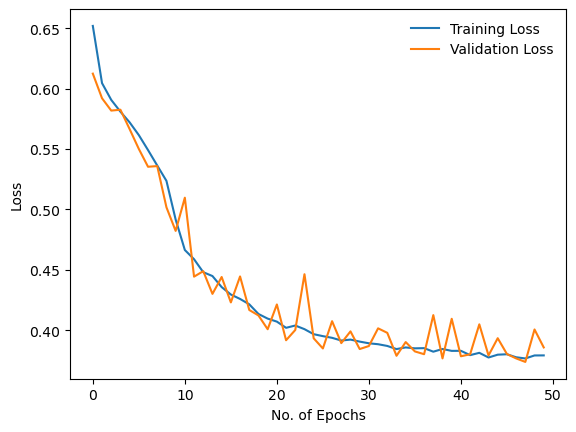

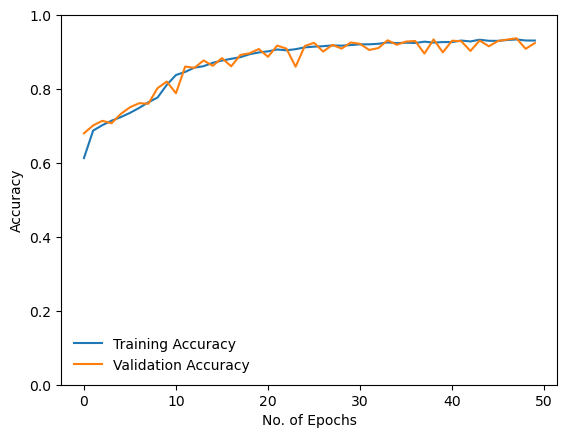

In [16]:
# Assuming train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history are already defined

# Plot training/validation loss
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

# Plot training/validation accuracy
plt.plot(train_accuracy_history, label="Training Accuracy")
plt.plot(val_accuracy_history, label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.ylim([0., 1.]) # Limit y axis between 0 and 1
plt.legend(frameon=False)
plt.show()


In [17]:
test_accuracy, average_test_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(test_accuracy)/len(test_accuracy)))

Accuracy: 0.93


In [18]:
model_export_path = "./SI_model/"
model_name = 'SI_CNN.pth'
os.makedirs(model_export_path, exist_ok=True)

#Save Pytorch model
def save_net(net, model_path, model_name):
    # Save PyTorch model
    model_full_path = os.path.join(model_path, model_name)
    torch.save(net.state_dict(), model_full_path)
    print(f'Model saved to {model_full_path}')

# Example usage
save_net(net, model_export_path, model_name)

Model saved to ./SI_model/SI_CNN.pth
